# Exercice 6
Résolvez l'équation de la chaleur homogène adimensionnelle :
$$ \frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0 \quad \forall x \in [0,1] $$
 	
avec des conditions de Dirichelet : $u(t, 0) = 0 = u(t, 1)$ $\forall t$ et une valeur initiale carrée : $u(0, x) = 1_{[0.25, 0.75]}$.

1. Implémentez une résolution spatiale en différences centrées d'ordre 2, et intégrez temporellement en utilisant les trois méthodes d'Euler;
2. Faites varier les paramètres et discutez de la stabilité.

## Solution
On définit la matrice liée aux différences centrées, de taille N+2 pour acceuillir les conditions de bord  (attention, pour une équation stationnaire telle que l'ex. 5 il n'est pas necéssaire de faire cet ajout).
$$
\mathbf{D} = \begin{pmatrix}
   &        &        &        &   \\
 1 & -2     & 1      &        &   \\
   & \ddots & \ddots & \ddots &   \\
   &        & 1      & -2     & 1 \\
   &        &        &        &   \\
\end{pmatrix}
$$

et 
$$ \lambda = \frac{ \Delta t }{ \Delta x^2 } $$

### Euler avant
$$\mathbf{u}^{n+1} = (\mathbf{I}+\lambda\mathbf{D})\mathbf{u}^{n}$$
### Euler arrière
$$\mathbf{u}^{n+1} = (\mathbf{I}-\lambda\mathbf{D})^{-1}\mathbf{u}^{n}$$
### Euler centré
$$\mathbf{u}^{n+1} = \left(\mathbf{I}-\frac{\lambda}{2}\mathbf{D}\right)^{-1}\left(\mathbf{I}+\frac{\lambda}{2}\mathbf{D}\right)\mathbf{u}^{n}$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des fonctions et constantes utiles

# Condition initiale carrée
def u0(x):
    return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

# Euler explicite
def euler_explicite(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    for n in range(N_t-1):
        u[n+1, :] = (np.eye(len(u0_vec)) + lmb * D) @ u[n, :]
        
    return t, u

# Euler implicite
def euler_implicite(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    A = np.eye(len(u0_vec)) - lmb * D
    A_inv = np.linalg.inv(A)
    
    for n in range(N_t-1):
        u[n+1, :] = A_inv @ u[n, :]
        
    return t, u

# Crank-Nicolson / Euler centré
def crank_nicolson(x, t_max, dt, u0_vec, D):
    # Initialisation
    dx = x[1] - x[0]
    lmb = dt / dx**2
    
    N_t = int(t_max/dt)+1
    
    t = np.linspace(0, t_max, N_t)
    u = np.zeros((N_t, len(u0_vec)))
    u[0,:] = u0_vec
    
    A = np.eye(len(u0_vec)) - lmb/2 * D
    A_inv = np.linalg.inv(A)
    
    AA =  A_inv @ (np.eye(len(u0_vec)) + lmb/2 * D)
    
    for n in range(N_t-1):
        u[n+1, :] = AA @ u[n, :]
        
    return t, u

# Solution analytique 
def u_exact(t_vec, a, b):
    x = np.linspace(0, 1, 1000)
    u = np.zeros((len(t_vec), len(x)))
    for (i, t_) in enumerate(t_vec):
        if t_ == 0:
            u[i,:] = u0(x)
            continue
        for p in range(1, 1000):
            lambdap = p * np.pi
            Ap = (2./(lambdap))*(np.cos(lambdap*a)-np.cos(lambdap*b))
            ui = Ap * np.exp(-lambdap**2*t_) * np.sin(lambdap*x)
            u[i,:] += ui
            if np.max(np.abs(ui)) < 1e-6:
                break
            
    return x, u

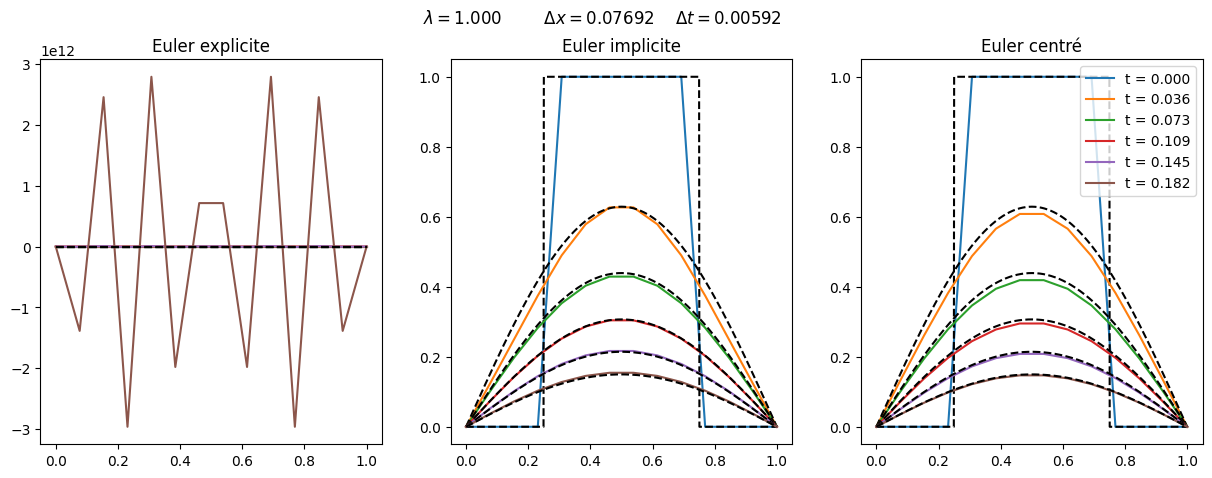

In [2]:
# Solution pour les conditions de Dirichelet
N = 12
lmb = 1.0 # either fix it or compute it from dx and dt
t_max = 0.2

x = np.linspace(0, 1, N+2) # on s'assure que les points de bord sont inclus
dx = x[1] - x[0]

# Condition CFL de stabilité : lmb < 0.5 pour Euler explicite
dt = lmb * dx**2

u0_vec = u0(x)
u0_vec[0] = 0.0
u0_vec[-1] = 0.0

D = np.zeros((N+2, N+2))
for i in range(1, N+1):
    D[i, i-1] = 1
    D[i, i] = -2
    D[i, i+1] = 1

t, u_EE = euler_explicite(x, t_max, dt, u0_vec, D)
_, u_EI = euler_implicite(x, t_max, dt, u0_vec, D)
_, u_CN = crank_nicolson(x, t_max, dt, u0_vec, D)
x_analytique, u_analytique = u_exact(t, 0.25, 0.75)

# Plot the solution at 5 different times, each method in a different subplot
t_idx_plot = range(0, len(t)-1, len(t)//5)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for t_idx in t_idx_plot:
    ax[0].plot(x, u_EE[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[0].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[0].set_title('Euler explicite')
    ax[1].plot(x, u_EI[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[1].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[1].set_title('Euler implicite')
    ax[2].plot(x, u_CN[t_idx,:], label = 't = %.3f' % t[t_idx])
    ax[2].plot(x_analytique, u_analytique[t_idx], 'k--')
    ax[2].set_title('Euler centré')
    ax[2].legend()

fig.suptitle('$\lambda = %.3f$ \t $\Delta x = %.5f$ \t $\Delta t = %.5f$' % (lmb, dx, dt))
plt.show()

In [3]:
%reset -f